# Bi-directional LSTM track-finding model

In this notebook, we try out a bi-directional LSTM to do current-layer hit predictions on the toy detector model of fixed-size, square detector layers.

The hope is that by adding the backward pass, it will give an improved classification of the hits on the current layer.

In [1]:
# System imports
import math
from __future__ import print_function

# External imports
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import layers

# Local imports
from metrics import calc_hit_accuracy
from toydata import generate_data, track_hit_coords
from drawing import draw_layers, draw_projections, draw_train_history

# Magic
%matplotlib notebook

Using Theano backend.
Using gpu device 0: GeForce GTX 980 Ti (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 4007)


In [2]:
# Set random seed
np.random.seed(2017)

## Utilities

In [3]:
def flatten_layers(data):
    """Flattens each 2D detector layer into a 1D array"""
    return data.reshape((data.shape[0], data.shape[1], -1))

## Data generation

In [4]:
num_det_layers = 10
det_layer_size = 32
num_seed_layers = 3
avg_bkg_tracks = 3
noise_prob = 0.01
det_shape = (num_det_layers, det_layer_size, det_layer_size)

In [5]:
def batch_generator(num_batch, det_shape=det_shape,
                    num_seed_layers=num_seed_layers,
                    avg_bkg_tracks=avg_bkg_tracks,
                    noise_prob=noise_prob):
    """Generator of toy data batches for training"""
    shape = (num_batch,) + det_shape
    while True:
        events, sig_tracks, _ = generate_data(
            shape, num_seed_layers=num_seed_layers,
            avg_bkg_tracks=avg_bkg_tracks,
            noise_prob=noise_prob, verbose=False)
        yield (flatten_layers(events), flatten_layers(sig_tracks))

## Define the model

In [19]:
def build_bilstm_model(length, dim, hidden_dim=100,
                       loss='categorical_crossentropy',
                       optimizer='Nadam', metrics=['accuracy']):
    """
    Build the bidirectional LSTM model.
    
    This is a sequence to sequence model with the following
    architecture:
        Input -> BiLSTM -> Dense -> Output
    Input and output data must have shape:
        (num_batch, length, dim).
    """
    inputs = layers.Input(shape=(length, dim))
    hidden = layers.Bidirectional(
        layers.LSTM(hidden_dim, return_sequences=True))(inputs)
    hidden = layers.TimeDistributed(
        layers.Dense(hidden_dim, activation='relu'))(hidden)
    outputs = layers.TimeDistributed(
        layers.Dense(dim, activation='softmax'))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

## Training

In [26]:
# Configure the model
hidden_dim = 256
#l2reg = 0.
#dropout = 0.

# Configure the training
batch_size = 128
num_event = 1920000
events_per_epoch = 64000
num_epoch = num_event / events_per_epoch

In [27]:
# Build the model
model = build_bilstm_model(num_det_layers, det_layer_size**2,
                           hidden_dim=hidden_dim)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 10, 1024)      0                                            
____________________________________________________________________________________________________
bidirectional_5 (Bidirectional)  (None, 10, 512)       2623488     input_5[0][0]                    
____________________________________________________________________________________________________
timedistributed_7 (TimeDistribute(None, 10, 256)       131328      bidirectional_5[0][0]            
____________________________________________________________________________________________________
timedistributed_8 (TimeDistribute(None, 10, 1024)      263168      timedistributed_7[0][0]          
Total params: 3017984
_____________________________________________________________________

In [28]:
history = model.fit_generator(batch_generator(batch_size),
                              samples_per_epoch=events_per_epoch,
                              nb_epoch=num_epoch)

Epoch 1/30
64000/64000 [==============================] - 25s - loss: 3.6525 - acc: 0.3492    
Epoch 2/30
64000/64000 [==============================] - 25s - loss: 1.5666 - acc: 0.6009    
Epoch 3/30
64000/64000 [==============================] - 25s - loss: 1.0361 - acc: 0.7128    
Epoch 4/30
64000/64000 [==============================] - 25s - loss: 0.8007 - acc: 0.7691    
Epoch 5/30
64000/64000 [==============================] - 25s - loss: 0.6613 - acc: 0.8052    
Epoch 6/30
64000/64000 [==============================] - 25s - loss: 0.5780 - acc: 0.8272    
Epoch 7/30
64000/64000 [==============================] - 25s - loss: 0.5132 - acc: 0.8448    
Epoch 8/30
64000/64000 [==============================] - 25s - loss: 0.4692 - acc: 0.8569    
Epoch 9/30
64000/64000 [==============================] - 25s - loss: 0.4414 - acc: 0.8649    
Epoch 10/30
64000/64000 [==============================] - 25s - loss: 0.4124 - acc: 0.8730    
Epoch 11/30
64000/64000 [========================

<IPython.core.display.Javascript object>


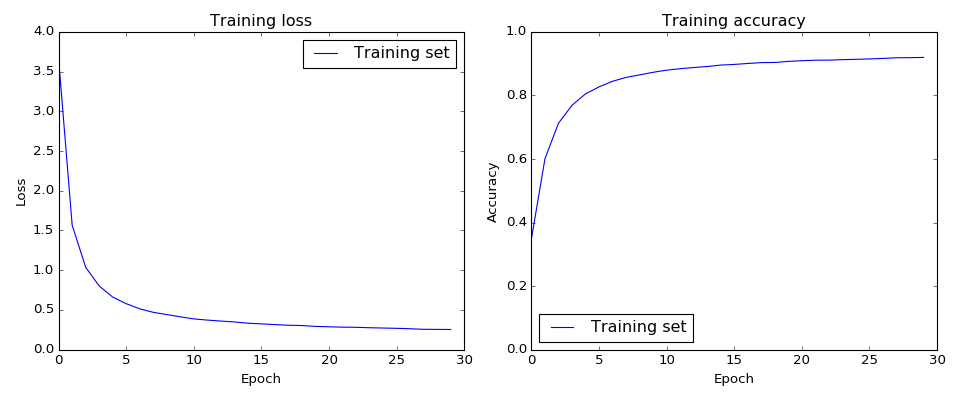

In [29]:
draw_train_history(history, draw_val=False)

## Evaluate results

In [11]:
# Generate a new test dataset
test_num_event = 51200
test_events, test_sigtrks, test_sigparams = generate_data(
    (test_num_event,) + det_shape, num_seed_layers=num_seed_layers,
    avg_bkg_tracks=avg_bkg_tracks, noise_prob=noise_prob)
test_input = flatten_layers(test_events)
test_target = flatten_layers(test_sigtrks)

Sizes of arrays
  events:     2097.15 MB
  sig_tracks: 2097.15 MB
  bkg_tracks: 2097.15 MB
  noise:      524.288 MB
  sig_params: 1.6384 MB


In [12]:
# Run the model on the test set
test_preds = model.predict(test_input, batch_size=batch_size)

In [15]:
# Hit prediction accuracy
pixel_accuracy = calc_hit_accuracy(test_preds, test_target,
                                   num_seed_layers=num_seed_layers)
# Hit classification accuracy
test_scores = test_preds * flatten_layers(test_events)
hit_accuracy = calc_hit_accuracy(test_scores, test_target)
print('Accuracy of predicted pixel:', pixel_accuracy)
print('Accuracy of classified hit: ', hit_accuracy)

Accuracy of predicted pixel: 0.9058677455357143
Accuracy of classified hit:  0.9384765625


Input data example event:


<IPython.core.display.Javascript object>


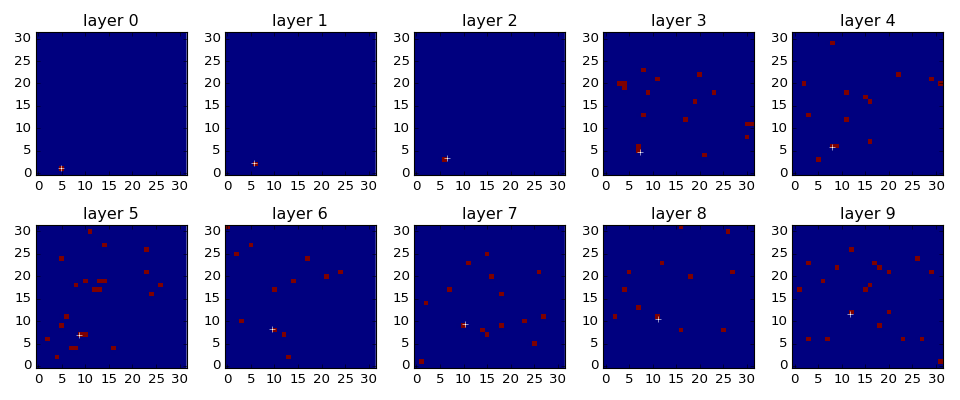

Model prediction:


<IPython.core.display.Javascript object>


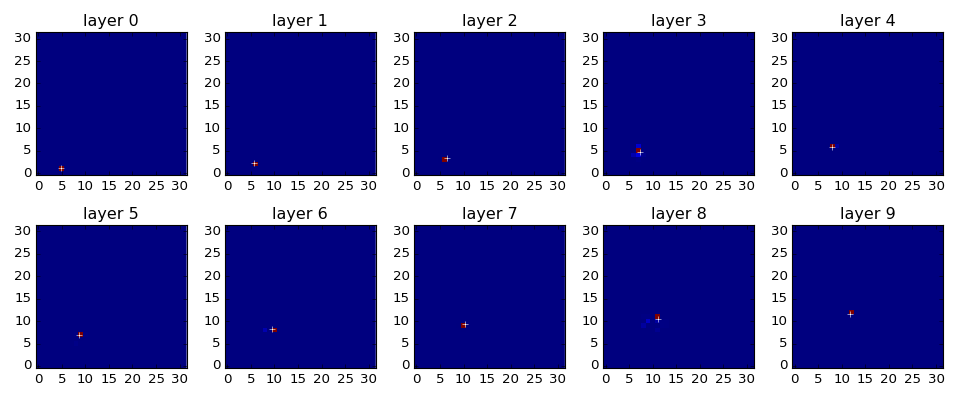

Projected input data:


<IPython.core.display.Javascript object>


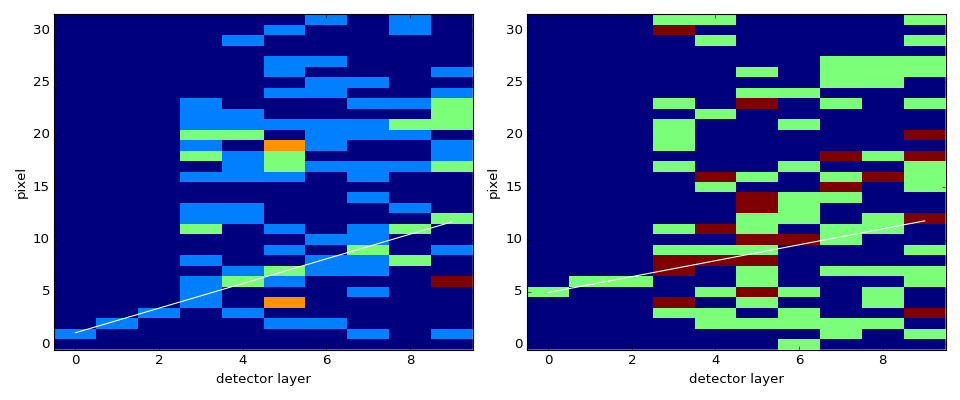

Projected model prediction:


<IPython.core.display.Javascript object>


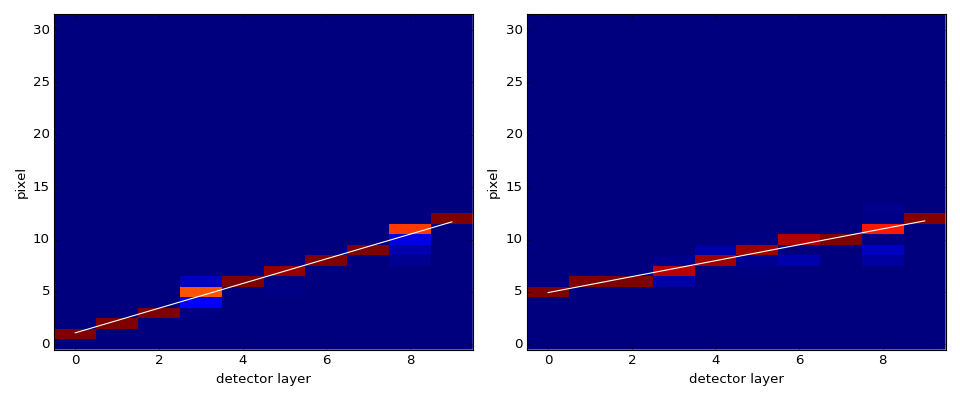

In [14]:
# Select an event to visualize
disp_idx = 1

# Get the hit coordinates for drawing
idx = np.arange(num_det_layers)
xtruth, ytruth = track_hit_coords(test_sigparams[disp_idx],
                                  idx, as_type=np.float32)

# Draw the layers
print('Input data example event:')
draw_layers(test_events[disp_idx], truthx=xtruth, truthy=ytruth)
print('Model prediction:')
draw_layers(test_preds[disp_idx].reshape(det_shape),
            truthx=xtruth, truthy=ytruth)
print('Projected input data:')
draw_projections(test_events[disp_idx], truthx=xtruth, truthy=ytruth)
print('Projected model prediction:')
draw_projections(test_preds[disp_idx].reshape(det_shape),
                 truthx=xtruth, truthy=ytruth)

## Conclusion

Utilizing current-layer predictions rather than next-layer predictions seems to work well.
In fact I see no reason to continue doing next-layer predictions despite some philosophical connection to Kalman Filter techniques.

The test set accuracy of classifying hits is >90%.